In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../data/processed/jokes.csv')
df.head()

,text,target
0,"В женскую баню заходит слепой. Все закричали, ...",0
1,"На похоронах:\n– Да, ни одна женщина не могла ...",1
2,Соблюдение всех правил не гарантирует торжеств...,0
3,У дачников свой гороскоп. Летом они становятся...,0
4,"На работе думала - приду домой, уберусь, блинч...",0


In [3]:
df['target'].value_counts()

target
0    9500
1     655
Name: count, dtype: int64

In [4]:
# check if 'text' has NaN values
df = df.dropna()
# get index of NaN values
print(df['text'].isna().sum())
df['target'].value_counts()

0


target
0    9500
1     655
Name: count, dtype: int64

In [5]:
import sys
import os
sys.path.append('..')
from src.preprocess import preprocess_text, tokenize_text

df['preprocessed'] = df.text.apply(preprocess_text)
df['tokenized'] = df['preprocessed'].apply(tokenize_text)
df['clean_text'] = df['tokenized'].apply(lambda x: " ".join(x))
df.head()

[nltk_data] Downloading package stopwords to /home/qosquo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,target,preprocessed,tokenized,clean_text
0,"В женскую баню заходит слепой. Все закричали, ...",0,в женскую баню заходит слепой все закричали ...,"[женский, баня, заходить, слепой, закричать, з...",женский баня заходить слепой закричать завизжа...
1,"На похоронах:\n– Да, ни одна женщина не могла ...",1,на похоронах \n да ни одна женщина не могла ...,"[похороны, один, женщина, мочь, отказать, наст...",похороны один женщина мочь отказать настоящий ...
2,Соблюдение всех правил не гарантирует торжеств...,0,соблюдение всех правил не гарантирует торжеств...,"[соблюдение, правило, гарантировать, торжество...",соблюдение правило гарантировать торжество закон
3,У дачников свой гороскоп. Летом они становятся...,0,у дачников свой гороскоп летом они становятся...,"[дачник, свой, гороскоп, лето, становиться, ра...",дачник свой гороскоп лето становиться рак водолей
4,"На работе думала - приду домой, уберусь, блинч...",0,на работе думала приду домой уберусь блинч...,"[работа, думать, прийти, домой, убраться, блин...",работа думать прийти домой убраться блинчик на...


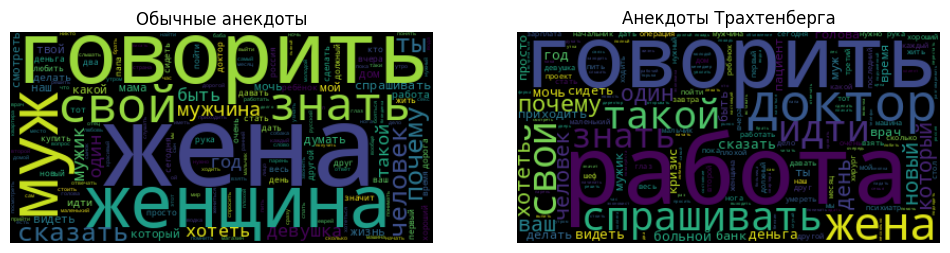

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
text_0 = " ".join(df[df.target == 0].clean_text.values)
text_1 = " ".join(df[df.target == 1].clean_text.values)
wordcloud_0 = WordCloud().generate(text_0)
wordcloud_1 = WordCloud().generate(text_1)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.title('Обычные анекдоты')
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Анекдоты Трахтенберга')
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.show()

In [48]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.feature_extraction.text import TfidfVectorizer

# векторизация токенов с использование TF-IDF
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 3), preprocessor=preprocess_text, tokenizer=tokenize_text, token_pattern=None)

X = tfidf.fit_transform(df.clean_text)
y = df.target

resampler = SMOTETomek(random_state=42, sampling_strategy=0.3)
X, y = resampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# сравним распределение целевого признака
print(f"Train: {y_train.value_counts() / len(y_train)}")
print(f"Test: {y_test.value_counts() / len(y_test)}")

Train: target
0    0.769044
1    0.230956
Name: count, dtype: float64
Test: target
0    0.773096
1    0.226904
Name: count, dtype: float64


In [36]:
from xgboost import XGBClassifier

model = XGBClassifier(
  booster='gbtree',
  objective='binary:logistic',
  scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
  verbosity=0
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [50]:
from sklearn.metrics import fbeta_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, poisson, expon, loguniform
from sklearn.metrics import make_scorer

distributions = {
  'lambda': loguniform(1e-2, 1e1),
  'eta': uniform(0, 1),
  'tree_method': ['auto', 'exact', 'approx'],
}
clf = RandomizedSearchCV(model, distributions, cv=5, scoring='f1')
search = clf.fit(X_train, y_train)
model = search.best_estimator_
print(search.best_params_)

{'eta': np.float64(0.39881963035310863), 'lambda': np.float64(0.018220132049490707), 'tree_method': 'exact'}


In [ ]:
from sklearn.metrics import f1_score, fbeta_score, confusion_matrix
y_pred = model.predict(X_test)

# метрики
print(f"Train F1: {f1_score(y_train, model.predict(X_train))}")
print(f"Test F1: {f1_score(y_test, y_pred)}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")

print(y_test[100:105])
model.predict_proba(X_test)[100:105]

Train F1: 0.9578125
Test F1: 0.8231046931407943
Confusion matrix:
[[908  46]
 [ 52 228]]
2310    0
9248    1
1433    0
5407    0
1213    0
Name: target, dtype: int64


array([[0.8352697 , 0.16473031],
       [0.18777126, 0.81222874],
       [0.91802835, 0.08197165],
       [0.88634807, 0.11365194],
       [0.80523276, 0.19476724]], dtype=float32)

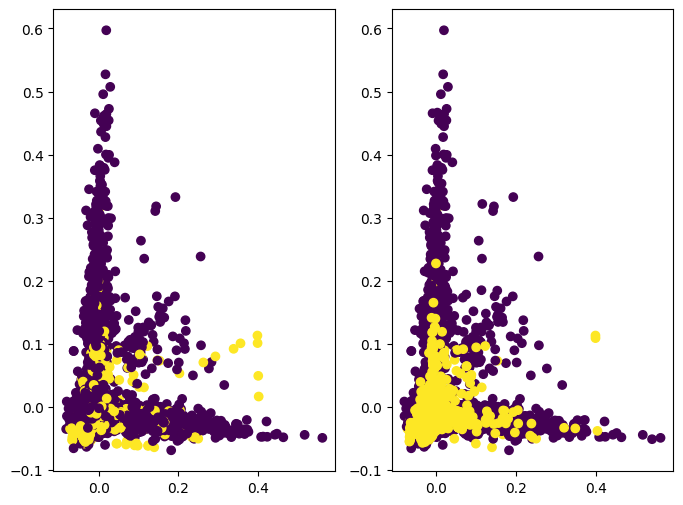

In [54]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# До SMOTE
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_train)

# После SMOTE
X_res_pca = pca.transform(X_train_res)
axes[1].scatter(X_res_pca[:, 0], X_res_pca[:, 1], c=y_train_res)
plt.show()

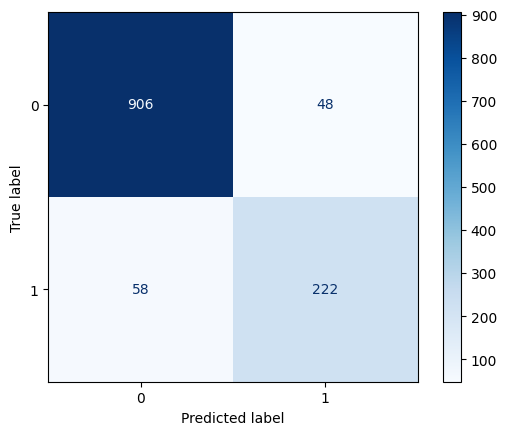

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay
# матриц ошибок
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize=None)
plt.show()

Оптимальный порог: 0.4183, F1: 0.84


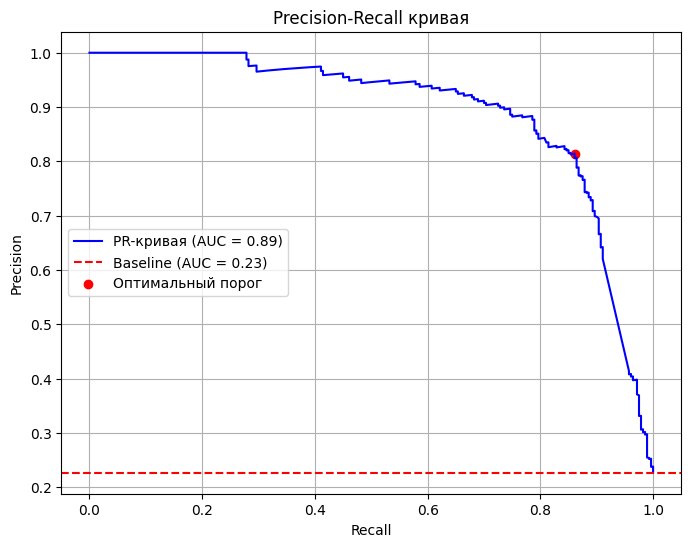

In [52]:
from sklearn.metrics import precision_recall_curve, auc

y_probs = model.predict_proba(X_test)[:, 1]
# Вычисляем precision, recall, пороги
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)  # Важно: передаем recall как x, precision как y

# Baseline (точность при случайном угадывании)
baseline = sum(y_test) / len(y_test)  # Доля положительных классов

# Строим график
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR-кривая (AUC = {pr_auc:.2f})', color='blue')
plt.axhline(baseline, linestyle='--', color='red', label=f'Baseline (AUC = {baseline:.2f})')

scores = 2 * (precision * recall) / (precision + recall + 1e-9)
# scores = (beta**2 + 1) * precision * recall / (beta**2 * precision + recall + 1e-9)
optimal_idx = np.argmax(scores)
optimal_threshold = thresholds[optimal_idx]
plt.scatter(recall[optimal_idx], precision[optimal_idx], marker='o', color='red', label='Оптимальный порог')
print(f"Оптимальный порог: {optimal_threshold:.4f}, F1: {scores[optimal_idx]:.2f}")

# Настройки
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
# проверю невиданный ранее моделью анекдот
new_text = """Как-то раз зять приходит к теще и говорит: 'Теща, я тут решил заняться спортом, чтобы быть в форме и радовать вас своим атлетическим телосложением. Можно?' А теща отвечает: 'Конечно, сынок! Только не забудь надеть свой новый спортивный костюм, который я тебе подарила, и кроссовки, которые я тебе тоже подарила. И не забудь взять полотенце и бутылку воды. И, конечно, не забудь про наушники, чтобы слушать мои советы по тренировкам!'"""
new_text_clean = " ".join(tokenize_text(preprocess_text(new_text)))
X_new = tfidf.transform([new_text_clean])
model.predict_proba(X_new)[0][1]

np.float32(0.42666632)

In [55]:
import joblib

joblib.dump(model, '../models/model.pkl')
joblib.dump(tfidf, '../models/tfidf_vectorizer.pkl')

['../models/tfidf_vectorizer.pkl']